In [1]:
# 1) Proper preprocessing for ResNet (v1) and separate, non-augmented validation gen
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

DATASET_PATH = "C:/Users/yagni/Downloads/dataset/Citrus Leaf Disease Image"
IMG_SIZE = 256
BATCH_SIZE = 32
VAL_SPLIT = 0.2
SEED = 42

train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,   # <-- match ResNet preprocessing
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=[0.9, 1.1],
    horizontal_flip=True,
    validation_split=VAL_SPLIT
)

# Validation generator: NO augmentation, same split/seed
val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=VAL_SPLIT
)

train_generator = train_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=SEED
)

val_generator = val_datagen.flow_from_directory(
    DATASET_PATH,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=SEED
)

num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print("Classes:", class_indices)

# 2) Optional: class weights for imbalance
y_train = train_generator.classes
classes = np.arange(num_classes)
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=classes,
                                     y=y_train)
class_weights = {i:w for i, w in enumerate(class_weights)}
print("Class weights:", class_weights)

# 3) Model (your same ResNet101 head)
from tensorflow.keras.applications import ResNet101
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet101(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer=Adam(1e-3), loss='categorical_crossentropy', metrics=['accuracy'])

# 4) Callbacks: LR scheduler and early stopping
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1)
]

# 5) Train head
history1 = model.fit(
    train_generator,
    epochs=15,
    validation_data=val_generator,
    class_weight=class_weights,      # remove if not desired
    callbacks=callbacks
)

# 6) Fine-tune: unfreeze and recompile with low LR
base_model.trainable = True
model.compile(optimizer=Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])  # recompile after unfreezing

history2 = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator, 
    class_weight=class_weights,
    callbacks=callbacks
)

# 7) Evaluate + diagnostics
loss, acc = model.evaluate(val_generator)
print(f"Validation accuracy: {acc*100:.2f}%")


Found 489 images belonging to 5 classes.
Found 118 images belonging to 5 classes.
Classes: {'Black spot': 0, 'Canker': 1, 'Greening': 2, 'Healthy': 3, 'Melanose': 4}
Class weights: {0: np.float64(0.7191176470588235), 1: np.float64(0.7465648854961832), 2: np.float64(0.5963414634146341), 3: np.float64(2.0808510638297872), 4: np.float64(8.89090909090909)}


C:\Users\yagni\AppData\Roaming\Python\Python313\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 146s 7s/step - accuracy: 0.6278 - loss: 1.4108 - val_accuracy: 0.7627 - val_loss: 0.6447 - learning_rate: 0.0010
Epoch 2/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 93s 6s/step - accuracy: 0.8814 - loss: 0.2625 - val_accuracy: 0.9492 - val_loss: 0.2637 - learning_rate: 0.0010
Epoch 3/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 90s 6s/step - accuracy: 0.9243 - loss: 0.1588 - val_accuracy: 0.9407 - val_loss: 0.2104 - learning_rate: 0.0010
Epoch 4/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 92s 6s/step - accuracy: 0.9407 - loss: 0.1154 - val_accuracy: 0.9492 - val_loss: 0.2057 - learning_rate: 0.0010
Epoch 5/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 110s 4s/step - accuracy: 0.9550 - loss: 0.0942 - val_accuracy: 0.9492 - val_loss: 0.2095 - learning_rate: 0.0010
Epoch 6/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 62s 4s/step - accuracy: 0.9714 - loss: 0.0748 - val_accuracy: 0.9407 - val_loss: 0.1943 - learning_rate: 0.0010
Epoch 7/15
16/16 ━━━━━━━━━━━━━━━━━━━━ 61s 4s/step - accuracy: 0.9591 - loss: 0.0636 - val_accuracy

In [2]:
# Optional: Save model
model.save("citrus_leaf_disease_model.h5")

In [3]:
pip install ipyfilechooser

Defaulting to user installation because normal site-packages is not writeableNote: you may need to restart the kernel to use updated packages.



In [4]:
from ipyfilechooser import FileChooser
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet import preprocess_input
import matplotlib.pyplot as plt

# Load model
model = tf.keras.models.load_model("citrus_leaf_disease_model.h5")
class_labels = ['Black spot', 'Canker', 'Greening', 'Healthy', 'Melanose']
IMG_SIZE = 256

# Create file chooser widget
fc = FileChooser()
display(fc)


FileChooser(path='C:\Users\yagni', filename='', title='', show_hidden=False, select_desc='Select', change_desc…

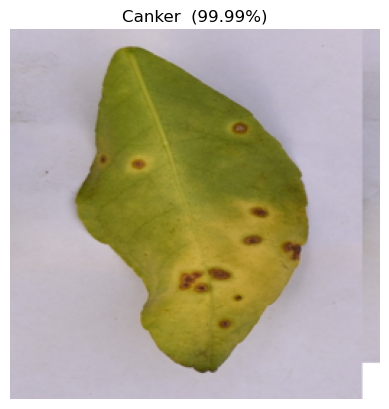

🖼️ Image (100).png → Canker (confidence: 99.99%)


In [17]:
import os
file_path = fc.selected

if file_path:
    img = image.load_img(file_path, target_size=(IMG_SIZE, IMG_SIZE))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)

    # Predict
    probs = model.predict(x, verbose=0)
    top = int(np.argmax(probs))
    pred, conf = class_labels[top], float(probs[0, top])

    # Display
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"{pred}  ({conf*100:.2f}%)")
    plt.show()

    print(f"🖼️ {os.path.basename(file_path)} → {pred} (confidence: {conf*100:.2f}%)")
else:
    print("❌ No file selected.")


In [6]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Predict class probabilities for validation data
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report (Precision, Recall, F1-score per class)
report = classification_report(y_true, y_pred, target_names=class_labels)
print("Classification Report:")
print(report)

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step
Confusion Matrix:
[[27  0  6  0  0]
 [ 2 28  2  0  0]
 [ 0  0 40  0  0]
 [ 0  0  1 10  0]
 [ 0  0  0  0  2]]
Classification Report:
              precision    recall  f1-score   support

  Black spot       0.93      0.82      0.87        33
      Canker       1.00      0.88      0.93        32
    Greening       0.82      1.00      0.90        40
     Healthy       1.00      0.91      0.95        11
    Melanose       1.00      1.00      1.00         2

    accuracy                           0.91       118
   macro avg       0.95      0.92      0.93       118
weighted avg       0.92      0.91      0.91       118

